In [1]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [2]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses
from __my_functions_flooddepth_houses import create_sample_houses_withinZone
from __my_functions_flooddepth_houses import calculate_first_qth_arrival_and_maxdepth
from __my_functions_flooddepth_houses import plot_flooddepth_houses_in_zone

### paths

In [3]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [4]:
general_path = 'E:/paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------

### load flood results

In [5]:
## flood scenario 
scenario_name = 'scen1_voorpiek'
simulation_name = 'lk_dh_test13_5verloop_2d'
## start_breach_time = '2000-01-01T18:00:00'
start_breach_time = '2000-01-01T00:00:00'


# scenario_name = 'scen2_napiek'
# simulation_name = 'lk_dh_test14_5verloop_38h'
# # start_breach_time = '2000-01-02T04:00:00'
# start_breach_time = '2000-01-01T00:00:00'

In [6]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)

In [7]:
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 48.00278541015558 uur
aantal tijdstappen: 577
interval: 300.05, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


----------------

## load buurten and houses in area

In [8]:
# buurten_scen2_test = gpd.read_file(f'{input_path}/buurten_scen2_test.shp')
buurten_new = gpd.read_file(f'{input_path}/cbs_buurten_fix.shp')
# buurten_scen2_test.columns

In [9]:
houses_all = gpd.read_file(f'{input_path}/huizen_centroid_flood_area_cleaned.shp')

------------------------------------------------------------

##  Testing on one zone

In [ ]:
random_index = 30
selected_zone = buurten_new.iloc[random_index]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom

In [ ]:
# specifieke zone
buurt_naam = 'Buitengebied Schagerbrug-Noord'

#oude sluis
# selected_zone = buurten_scen2_test.loc[buurten_scen2_test.BU_CODE == 'BU04410901']
selected_zone = buurten_scen2_test.loc[buurten_scen2_test.BU_NAAM == buurt_naam]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom.plot()

#### 1) create sample

In [ ]:
samplesize = 14
zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone )
print(f'zone name: {zone_name}')
houses_df.head(1)

#### 2)  compute flood depth(t)at this sample

In [10]:
flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                houses_df, gr, time_humanized, last_timestamp, output_path)
len(flooddepth_time_houses_df)

NameError: name 'samplesize' is not defined

In [ ]:
len(flooddepth_time_houses_df.columns)

In [ ]:
zones_depth_time_df =  pd.DataFrame( index = time_humanized)
zone_name = zone_name

for index, row in flooddepth_time_houses_df.iterrows():
    flooddepths = row.values
    max_depth_qt = np.quantile(flooddepths,0.95)
    
    zones_depth_time_df.loc[index, zone_name] = max_depth_qt
    
    
zones_depth_time_df    

#### 3)  compute one value first arrival and max depth for zone

In [ ]:
first_qth_arrival, max_depth, max_depth_qt = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)
print(f'first arrival: {first_qth_arrival}')
# print(f'max depth: {max_depth}')
# print(f'max depth qt: {max_depth_qt}')


#### 4) plot flood depth in zone

In [ ]:
plot_flooddepth_houses_in_zone(zone_name,flooddepth_time_houses_df, first_qth_arrival,max_depth, max_depth_qt, time_humanized, output_path)

----------------------------

---------

## selection of zones

In [11]:
len_all_zones = len(buurten_new)
len_all_zones

89

#### choose sample size

In [12]:
nr_zones_sampling = 89
samplesize_nr_houses_in_zone = 50

In [13]:
selected_zones = buurten_new.sample(nr_zones_sampling)

In [14]:
def create_zones_maxdepth_arrival_df(houses_all, selected_zones, samplesize_nr_houses_in_zone, 
                                     scenario_name, gr, time_humanized, last_timestamp, output_path):
    
    #make df based on zone_selection
    zones_maxdepth_arrival_df = selected_zones[["BU_NAAM", 'geometry', 'AANT_INW']].copy()
    zones_maxdepth_arrival_df["maxdepth"] = np.nan
    zones_maxdepth_arrival_df["maxdepth_qt"] = np.nan
    zones_maxdepth_arrival_df["arrival"] = np.nan
    zones_maxdepth_arrival_df
    
    ## df with zones max depth over time
    zones_depth_time_df = pd.DataFrame( index = time_humanized)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    
    samplesize = samplesize_nr_houses_in_zone

    # loop over alle zones
    for index, row in zones_maxdepth_arrival_df.iterrows():
    
        gpd.GeoSeries(row.geometry).plot(ax=ax, color="#dee2e6")
        
        selected_zone = zones_maxdepth_arrival_df.loc[zones_maxdepth_arrival_df.BU_NAAM == row.BU_NAAM]
    

        #create sample for all seleced zones
        zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone )
        

        #indien er geen huizen in de zone zijn, continue to next loop
        if len(houses_df) == 0:
            continue

        else:

            # compute flood depth(t)at this sample
            flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                    houses_df, gr, time_humanized, last_timestamp, output_path)

            ## continue when no depth
            if len(flooddepth_time_houses_df.columns) == 0:
                continue

            else:

                # compute one value first arrival and max depth for zone
                first_qth_arrival_dt, max_depth, max_depth_qt  = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df, zone_name)

                print(first_qth_arrival_dt)
                print('----')
                if max_depth > 0:
                    zones_maxdepth_arrival_df.loc[index, "maxdepth"] = max_depth
                    zones_maxdepth_arrival_df.loc[index, "maxdepth_qt"] = max_depth_qt

                    
                if first_qth_arrival_dt != np.nan:
                    zones_maxdepth_arrival_df.loc[index, "arrival"] = first_qth_arrival_dt
                    
                
                ## fil zones_depth_time_df
                for index, row in flooddepth_time_houses_df.iterrows():
                    flooddepths = row.values
                    max_depth_qt_time = np.quantile(flooddepths,0.95)

                    zones_depth_time_df.loc[index, zone_name] = max_depth_qt_time


                  




                #plot flood depth in zone
                plot_flooddepth_houses_in_zone(zone_name, 
                                       flooddepth_time_houses_df, 
                                       first_qth_arrival_dt, 
                                       max_depth, 
                                       max_depth_qt, 
                                       time_humanized, 
                                        scenario_name,
                                       output_path)

    return zones_maxdepth_arrival_df, zones_depth_time_df

nr houses in 39    Boerderijbuurt
Name: BU_NAAM, dtype: object: 973
too many, therefor sample of 50 houses taken
flood values for Boerderijbuurt
----------------------
first_qth_arrival: 946685103.0
first_qth_arrival_dt: 2000-01-01 01:05:03
max_depth_qt : 2.3675015258568033
max_depth: 2.397723064563047
2000-01-01 01:05:03
----
nr houses in 15    Tuindorp-West
Name: BU_NAAM, dtype: object: 1287
too many, therefor sample of 50 houses taken
flood values for Tuindorp-West
----------------------
first_qth_arrival: 946683003.0
first_qth_arrival_dt: 2000-01-01 00:30:03
max_depth_qt : 2.8739004738732663
max_depth: 2.9432926356462445
2000-01-01 00:30:03
----
nr houses in 34    Westoever
Name: BU_NAAM, dtype: object: 148
too many, therefor sample of 50 houses taken
flood values for Westoever
----------------------
first_qth_arrival: 946684503.0
first_qth_arrival_dt: 2000-01-01 00:55:03
max_depth_qt : 2.4199461129138746
max_depth: 2.6848429146856825
2000-01-01 00:55:03
----
nr houses in 17    For

nr houses in 70    Kolksluis
Name: BU_NAAM, dtype: object: 52
too many, therefor sample of 50 houses taken
flood values for Kolksluis
----------------------
first_qth_arrival: 946711744.4
first_qth_arrival_dt: 2000-01-01 08:29:04.400000
max_depth_qt : 0.5039567425725007
max_depth: 0.505925279236187
2000-01-01 08:29:04.400000
----
nr houses in 5    Visbuurt
Name: BU_NAAM, dtype: object: 1913
too many, therefor sample of 50 houses taken
flood values for Visbuurt
----------------------
first_qth_arrival: 946683603.0
first_qth_arrival_dt: 2000-01-01 00:40:03
max_depth_qt : 2.88638019624434
max_depth: 3.2801871944585415
2000-01-01 00:40:03
----
nr houses in 50    Koegras-Zuid
Name: BU_NAAM, dtype: object: 33
all houses in zones taken
flood values for Koegras-Zuid
----------------------
first_qth_arrival: 946690743.0
first_qth_arrival_dt: 2000-01-01 02:39:03
max_depth_qt : 3.1241256349117914
max_depth: 3.216621644742051
2000-01-01 02:39:03
----
nr houses in 22    Duinbuurt
Name: BU_NAAM, dty

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 84    Van Ewijcksluis
Name: BU_NAAM, dtype: object: 170
too many, therefor sample of 50 houses taken
flood values for Van Ewijcksluis
----------------------
first_qth_arrival: 946740300.0
first_qth_arrival_dt: 2000-01-01 16:25:00
max_depth_qt : 1.127133056079595
max_depth: 1.2231330560795948
2000-01-01 16:25:00
----
nr houses in 27    Kleine Rivierenbuurt
Name: BU_NAAM, dtype: object: 237
too many, therefor sample of 50 houses taken
flood values for Kleine Rivierenbuurt
----------------------
first_qth_arrival: 946683903.0
first_qth_arrival_dt: 2000-01-01 00:45:03
max_depth_qt : 2.523024957069028
max_depth: 2.5664241025911303
2000-01-01 00:45:03
----
nr houses in 85    Oostpolder
Name: BU_NAAM, dtype: object: 204
too many, therefor sample of 50 houses taken
nr houses in 52    Mariëndal
Name: BU_NAAM, dtype: object: 48
all houses in zones taken
flood values for Mariëndal
----------------------
first_qth_arrival: 946687653.0
first_qth_arrival_dt: 2000-01-01 01:47:33
max_dept

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 81    Kleine Sluis inclusief Spoorbuurt
Name: BU_NAAM, dtype: object: 4543
too many, therefor sample of 50 houses taken
flood values for Kleine Sluis inclusief Spoorbuurt
----------------------
first_qth_arrival: 946725004.0
first_qth_arrival_dt: 2000-01-01 12:10:04
max_depth_qt : 1.0043947086253389
max_depth: 1.23135522136158
2000-01-01 12:10:04
----
nr houses in 80    Verspreide huizen Slootdorp
Name: BU_NAAM, dtype: object: 0
all houses in zones taken


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 66    Oudesluis (woonkern)
Name: BU_NAAM, dtype: object: 437
too many, therefor sample of 50 houses taken
flood values for Oudesluis (woonkern)
----------------------
first_qth_arrival: 946681510.0
first_qth_arrival_dt: 2000-01-01 00:05:10
max_depth_qt : 0.1331089555190994
max_depth: 0.13832521633589412
2000-01-01 00:05:10
----
nr houses in 36    Schouten en Schepenenbuurt
Name: BU_NAAM, dtype: object: 987
too many, therefor sample of 50 houses taken
flood values for Schouten en Schepenenbuurt
----------------------
first_qth_arrival: 946684503.0
first_qth_arrival_dt: 2000-01-01 00:55:03
max_depth_qt : 2.3755658856286375
max_depth: 2.3882562537677448
2000-01-01 00:55:03
----
nr houses in 75    Zwanenwater
Name: BU_NAAM, dtype: object: 6
all houses in zones taken
flood values for Zwanenwater
----------------------
first_qth_arrival: 946724103.5
first_qth_arrival_dt: 2000-01-01 11:55:03.500000
max_depth_qt : 1.4393755244707434
max_depth: 1.5843719873128688
2000-01-01 11:55:0

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 23    Donkere Duinen
Name: BU_NAAM, dtype: object: 15
all houses in zones taken
flood values for Donkere Duinen
----------------------
first_qth_arrival: 946687563.0
first_qth_arrival_dt: 2000-01-01 01:46:03
max_depth_qt : 1.7494409538146247
max_depth: 1.7897227155376316
2000-01-01 01:46:03
----
nr houses in 16    Tuindorp-Oost
Name: BU_NAAM, dtype: object: 550
too many, therefor sample of 50 houses taken
flood values for Tuindorp-Oost
----------------------
first_qth_arrival: 946683303.0
first_qth_arrival_dt: 2000-01-01 00:35:03
max_depth_qt : 2.8433841323650997
max_depth: 2.861679455265117
2000-01-01 00:35:03
----
nr houses in 19    Huisduinen
Name: BU_NAAM, dtype: object: 461
too many, therefor sample of 50 houses taken
flood values for Huisduinen
----------------------
first_qth_arrival: 946682402.0
first_qth_arrival_dt: 2000-01-01 00:20:02
max_depth_qt : 1.7260342102472237
max_depth: 1.829134210247224
2000-01-01 00:20:02
----
nr houses in 3    Willemsoord
Name: BU_NAA

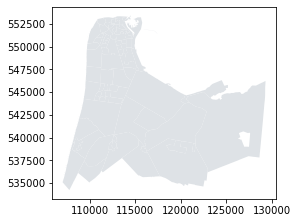

In [15]:
zones_maxdepth_arrival_df, zones_depth_time_df = create_zones_maxdepth_arrival_df(houses_all, selected_zones, samplesize_nr_houses_in_zone, scenario_name, gr, time_humanized, last_timestamp, output_path)

------------------------------------------

In [16]:
zones_maxdepth_arrival_df.head(3)

,BU_NAAM,geometry,AANT_INW,maxdepth,maxdepth_qt,arrival
39,Boerderijbuurt,"POLYGON ((113433.000 550215.813, 113452.500 55...",1110,2.397723,2.367502,2000-01-01 01:05:03
15,Tuindorp-West,"POLYGON ((112958.898 551878.625, 112937.602 55...",1685,2.943293,2.873900,2000-01-01 00:30:03
34,Westoever,"POLYGON ((114067.297 551574.125, 114054.501 55...",0,2.684843,2.419946,2000-01-01 00:55:03


In [17]:
zones_depth_time_df.tail()

,Boerderijbuurt,Tuindorp-West,Westoever,Fort Erfprins,Julianadorp-Oost,Waterkeringsbuurt,Marinehaven,Landmetersbuurt,Van Galenbuurt,Koegras-Noord,...,Huisduinen,Willemsoord,Oostsloot,Callantsoog (woonkern),Friesebuurt,Oostoever,Uyterland,Buitengebied 't Zand-Oost,Deltabuurt,Nieuwlandbuurt
2000-01-02 23:40:04,0.989299,1.399784,0.988434,1.513420,1.624260,1.036917,0.038598,1.070655,1.454335,1.836446,...,0.035480,1.065861,1.532510,1.547686,1.845398,1.421299,1.863164,0.310307,1.478934,1.148381
2000-01-02 23:45:05,0.987348,1.397783,0.986461,1.511193,1.622352,1.034966,0.038598,1.068720,1.452299,1.834540,...,0.033306,1.063857,1.530499,1.546639,1.843475,1.420681,1.862117,0.310307,1.476979,1.146397
2000-01-02 23:50:09,0.985383,1.395754,0.984467,1.508940,1.620438,1.033019,0.038598,1.066756,1.450237,1.832623,...,0.031113,1.061819,1.528458,1.545584,1.841513,1.420060,1.861062,0.310307,1.475007,1.144400
2000-01-02 23:55:01,0.983508,1.393800,0.982550,1.506849,1.618601,1.031137,0.038598,1.064887,1.448252,1.830787,...,0.029016,1.059847,1.526482,1.544571,1.839648,1.419465,1.860049,0.310307,1.473117,1.142480
2000-01-03 00:00:10,0.981516,1.391735,0.980523,1.504711,1.616664,1.029153,0.038598,1.062903,1.446152,1.828848,...,0.026887,1.057762,1.524391,1.543502,1.837662,1.418837,1.858979,0.310307,1.471116,1.140451


In [18]:
# zones_maxdepth_arrival_df_dropna = zones_maxdepth_arrival_df.dropna()

In [19]:
#datetime to string for export
zones_maxdepth_arrival_df_str = zones_maxdepth_arrival_df.copy()
zones_maxdepth_arrival_df_str['arrival'] = zones_maxdepth_arrival_df["arrival"].apply(str)
zones_maxdepth_arrival_df_str.to_file(f'{output_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.geojson', drive="GeoJSON")


## WRITING FILES ##
zones_depth_time_df.to_json(f'{output_path}/zones_depth_time_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.json')


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [31]:
zones_depth_time_df.plot(color = '#023047', alpha= 0.2)

SyntaxError: keyword argument repeated: color (3854790612.py, line 1)